This notebook implement I-PINN on the steady-state problem of a parametric ellipsoid inside a unit cube. The permeability inside the ellipsoid is $\mu=1$ and outside the ellipsoid is $\mu=1.5$. The ellipsoid is defined as $$ \sqrt{(x-0.5)^2 + (y-0.5)^2  + (\frac{z-0.5}{a})^2 }= 0.2. $$ The input of the neural network are the spacial coordinates and $a$.

In [ ]:
import numpy as np
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace
import matplotlib.pyplot as plt

Define the functions necessary to calculate the residual of Maxwells equations. We use the first order, steady-state system of equations.

In [2]:
def get_derivH(H,Y):

    gH=torch.autograd.grad(H,Y,grad_outputs=torch.ones_like(H),retain_graph=True,create_graph=True, allow_unused=True)[0]
    H_x=gH[:,0:1]
    H_y=gH[:,1:2]
    H_z=gH[:,2:3]
    return H_x , H_y, H_z

def T_curl(Hx,Hy,Hz,Y):
    Hx_x , Hx_y, Hx_z = get_derivH(Hx,Y)
    Hy_x , Hy_y, Hy_z = get_derivH(Hy,Y)
    Hz_x , Hz_y, Hz_z = get_derivH(Hz,Y)

    c1=(Hz_y-Hy_z)
    c2=(Hx_z-Hz_x)
    c3=(Hy_x-Hx_y)
    div=Hx_x + Hy_y + Hz_z
    return c1,c2,c3, div

def equa_F(Hx,Hy,Hz,Ex,Ey,Ez,Y):
    k=Y[:,3:4]


    rho=1

    cH1,cH2,cH3,div = T_curl(Hx,Hy,Hz,Y)

    cE1,cE2,cE3,divE = T_curl(Ex,Ey,Ez,Y)

    resx= cE1
    resy= cE2
    resz= cE3

    res2x=Ex*1/rho-cH1
    res2y=Ey*1/rho-cH2
    res2z=Ez*1/rho-cH3

    return resx,resy,resz, res2x,res2y,res2z,div,divE



We define the I-PINN architecture, with strong imposition of boundary conditions.

In [2]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #m.bias.data.fill_(0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NetF(nn.Module):
    def __init__(self):
        super().__init__()
        n=75
        k=1

        self.base = nn.Sequential(
          nn.Linear(12,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),

        )
        self.head1 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head2 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head3 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head4 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head5 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head6 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
    def forward(self, x):
        k=1
        c=0
        r= F(x)

        mu=torch.sigmoid(50*(0.2-r ) )
        mux,muy,muz=get_derivH(mu,x)
        mod= 50*0.25 #max(mux) #torch.sqrt(mux**2 + muy**2 + muz**2)

        mu1=torch.sigmoid(50*(0.2-r))
        mu2=torch.sigmoid(100*(0.2-r))
        mu3=torch.sigmoid(200*(0.2-r))
        mu4=torch.sigmoid(400*(0.2-r))

        Xa=torch.column_stack((x,mu,mu1,mu2,mu3,mu4,mux/mod,muy/mod,muz/mod))

        x1 = self.base(Xa)


        x2=self.head1(x1)
        x3=self.head2(x1)
        x4=self.head3(x1)
        x5=self.head4(x1)
        x6=self.head5(x1)
        x7=self.head6(x1)

        return x2 ,x3, x4 ,x5,x6 ,x7

netF = NetF()
netF.apply(init_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
netF=netF.to(device)

def for_pass_F(X):
    Bx,By,Bz,Dx,Dy,Dz=netF(X)

    w1=X[:,0:1]
    w2=X[:,1:2]
    w3=1-w1
    w4=1-w2
    hb = X[:,2:3]
    ht = 1-hb

    d1= 1-torch.exp(-w1*1)
    d2= 1-torch.exp(-w2*1)
    d3= 1-torch.exp(-w3*1)
    d4= 1-torch.exp(-w4*1)
    d5= 1-torch.exp(-hb*1)
    d6= 1-torch.exp(-ht*1)




    Hx = Bx*d2*d4*d5*d6
    Hy = By*d1*d3*d5*d6
    Hz = Bz *d1*d2*d3*d4 + 1

    Ex = Dx*d1*d3
    Ey = Dy*d2*d4
    Ez = Dz*d5*d6



    return Hx,Hy,Hz,Ex,Ey,Ez


netF.apply(init_weights)

In [16]:
L=[]

PLot function to keep track of the predicted magnetic field during training.

In [29]:
def plot_results():

    Xt= get_x(5000).to(device)

    Xt[:,0]=0.5
    Xt[:,1]=0.5
    a=0.5
    Xt[:,3:4]=a

    Xt.requires_grad=True

    Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(Xt)
    r=F(Xt)
    mu=Xt[:,3:4]*torch.sigmoid(4*100*(r-0.2)) + 1


    plt.plot(Xt[:,2].detach().cpu(),Hz.detach().cpu(),'*')
    plt.grid()


    plt.pause(0.005)


Functions to obtain a point distribution suitable for the problem, with a denser distribution around the interface

In [18]:
def F(x):
  X = x[:,0:1] -0.5
  Y = x[:,1:2] -0.5
  Z = (x[:,2:3]-0.5)/ (x[:,3:4])
  r = torch.sqrt(X**2 + Y**2 +Z**2)
  return r

def get_x(N):
  X=np.random.uniform(0,1,(N,4))
  X[:,3:4]= np.random.uniform(0.2,0.6,(N,1))
  X=torch.tensor(X).float()
  return X

def remesh(X0,N,n):
  X=get_x(N)
  X.requires_grad=True
  X = X.to(device)
  Rm=1


  r=F(X)

  mu=0.5*torch.sigmoid(4*100*(r-0.2)) + 1


  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

  tag=0
  resx,resy,resz, res2x,res2y,res2z,div,divE = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X)
  cH1,cH2,cH3,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

  V= resx**2+resy**2+resz**2+ res2x**2+res2y**2+res2z**2+divH**2+divE**2


  nmax=torch.topk(V.reshape(-1), n).indices
  Xout=torch.concatenate((X0,X.detach()[nmax,:]) )
  return Xout

In [21]:
X= get_x(40000).to(device)

X=remesh(X,200000,20000)

In [22]:

X.shape

torch.Size([60000, 4])

In [23]:

X.requires_grad=True
X = X.to(device)

**Training iterations**

In [25]:
def closure():
  Rm=1
  r=F(X)
  mu=0.5*torch.sigmoid(4*100*(r-0.2)) + 1

  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

  resx,resy,resz, res2x,res2y,res2z,div,divE  = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X)
  cH1,cH2,cH3,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

  loss1=1*criterion(resx*T,resx*0) + 1*criterion(resy*T,resy*0) + 1*criterion(resz*T,resz*0) + 1*criterion(divH*T,divH*0)
  loss2=1*criterion(res2x*T,res2x*0) + 1*criterion(res2y*T,res2y*0) + 1*criterion(res2z*T,res2z*0) + 1*criterion(divE*T,divE*0)


  loss=1*loss1 + 1*loss2
  optimizer.zero_grad()

  L.append(loss.detach().cpu().numpy())

  loss.backward()
  return loss


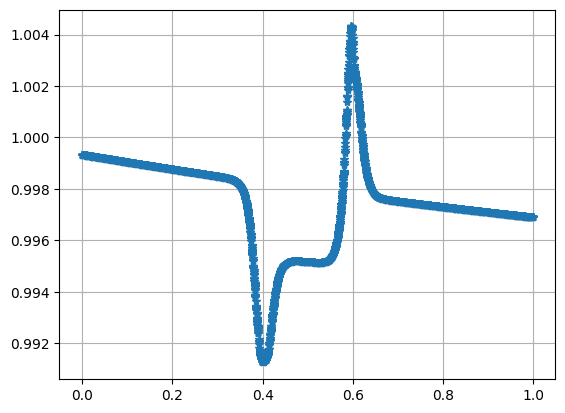

tensor(32.4959, device='cuda:0', grad_fn=<MulBackward0>)
tensor(26.6359, device='cuda:0', grad_fn=<MulBackward0>)
tensor(17.6013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7.4481, device='cuda:0', grad_fn=<MulBackward0>)
tensor(6.1577, device='cuda:0', grad_fn=<MulBackward0>)
tensor(5.1551, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.8813, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.4857, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2627, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0269, device='cuda:0', grad_fn=<MulBackward0>)


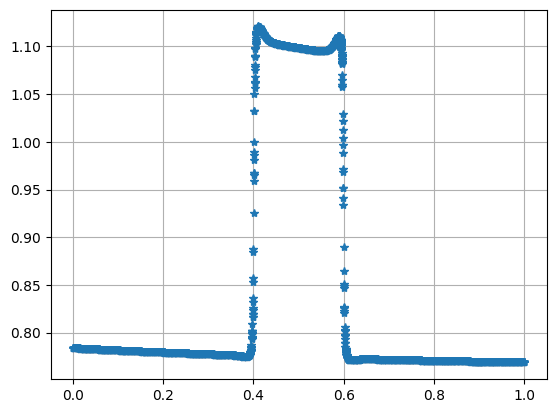

tensor(3.7702, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4643, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0831, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6557, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2849, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.0285, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.8485, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.7127, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.5202, device='cuda:0', grad_fn=<MulBackward0>)


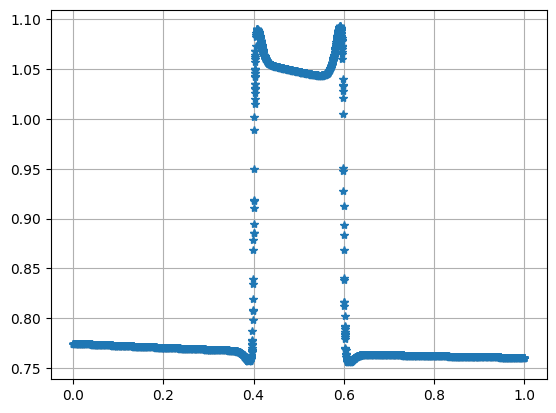

tensor(1.4464, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.3840, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.3334, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2935, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2609, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2322, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2060, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1818, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1594, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1392, device='cuda:0', grad_fn=<MulBackward0>)


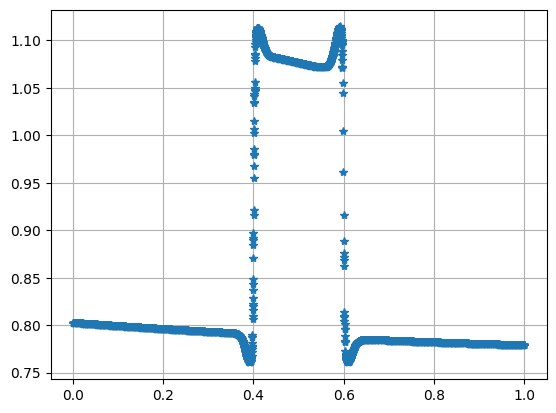

tensor(1.1173, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0975, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0780, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0591, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0403, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0218, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.0034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9850, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9667, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9484, device='cuda:0', grad_fn=<MulBackward0>)


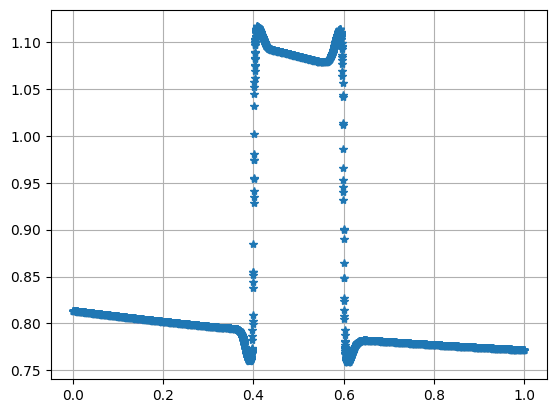

tensor(0.9302, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9120, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8938, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8758, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8579, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8401, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8228, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8054, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7884, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7714, device='cuda:0', grad_fn=<MulBackward0>)


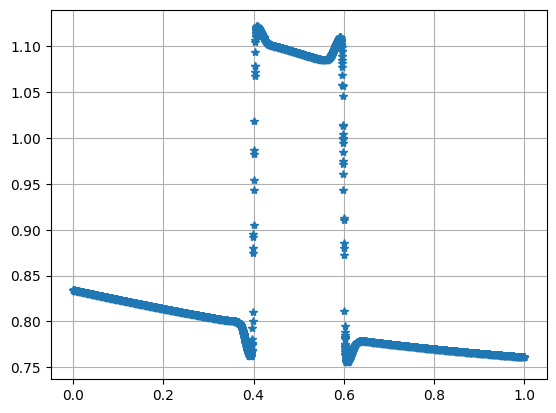

tensor(0.7547, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7385, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7226, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7071, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6922, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6776, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6635, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6505, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6365, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6236, device='cuda:0', grad_fn=<MulBackward0>)


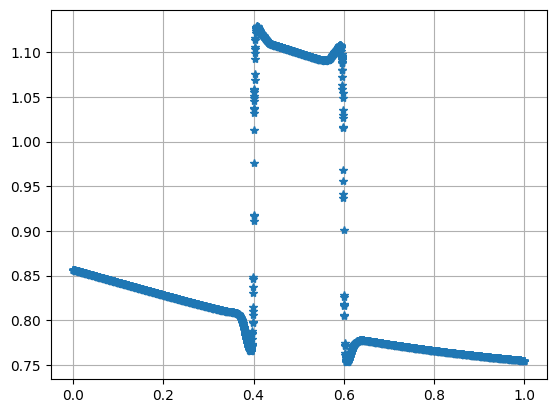

tensor(0.6110, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5988, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5868, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5752, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5638, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5430, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5319, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5212, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5108, device='cuda:0', grad_fn=<MulBackward0>)


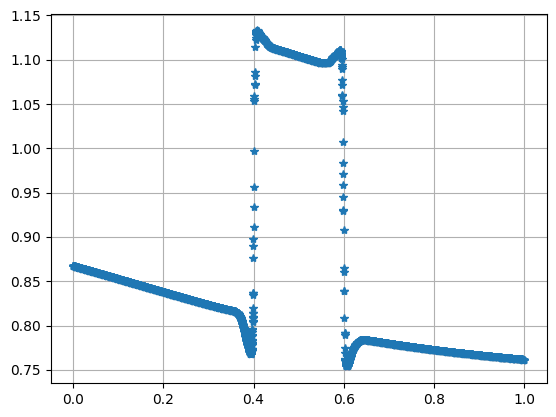

tensor(0.5007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4909, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4813, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4718, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4628, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4533, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4441, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4353, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4276, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4179, device='cuda:0', grad_fn=<MulBackward0>)


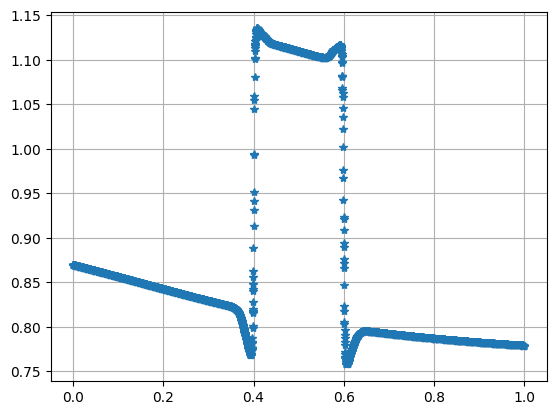

tensor(0.4092, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3945, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3845, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3767, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3689, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3614, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3472, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3403, device='cuda:0', grad_fn=<MulBackward0>)


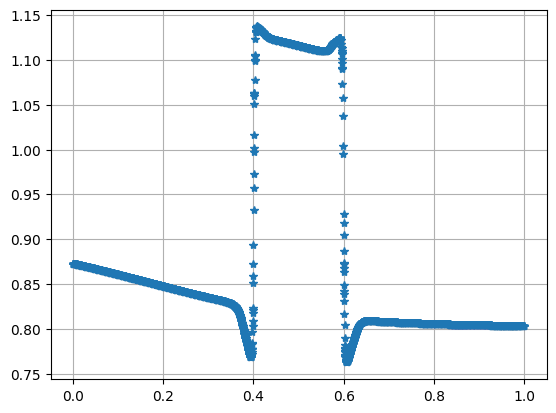

tensor(0.3332, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3267, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3203, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3141, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3082, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2971, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2918, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2867, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2818, device='cuda:0', grad_fn=<MulBackward0>)


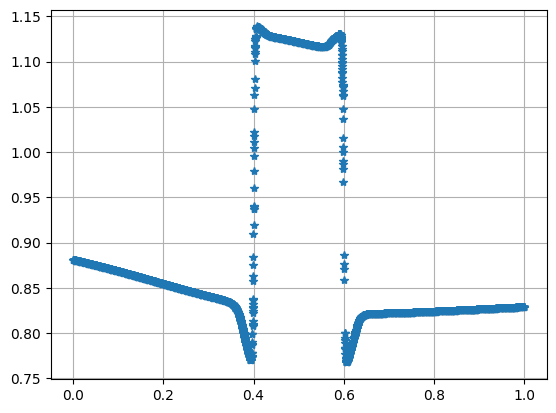

tensor(0.2799, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2739, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2688, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2639, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2598, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2558, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2482, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2445, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2410, device='cuda:0', grad_fn=<MulBackward0>)


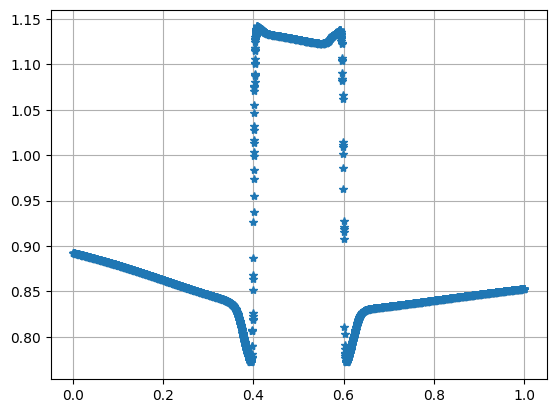

tensor(0.2376, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2343, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2316, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2284, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2252, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2221, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2193, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2166, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2139, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2113, device='cuda:0', grad_fn=<MulBackward0>)


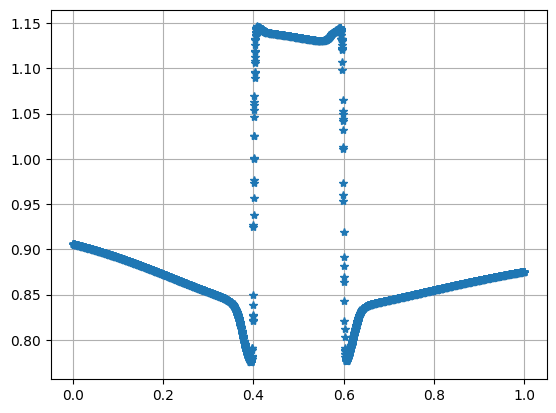

tensor(0.2089, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2085, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2054, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1999, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1975, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1955, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1934, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1915, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1896, device='cuda:0', grad_fn=<MulBackward0>)


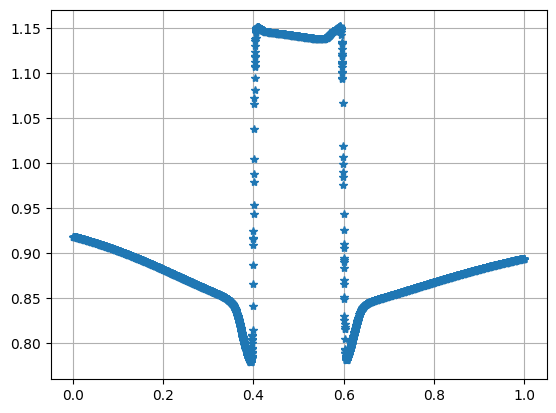

tensor(0.1877, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1859, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1842, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1825, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1808, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1792, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1781, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1771, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1772, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1734, device='cuda:0', grad_fn=<MulBackward0>)


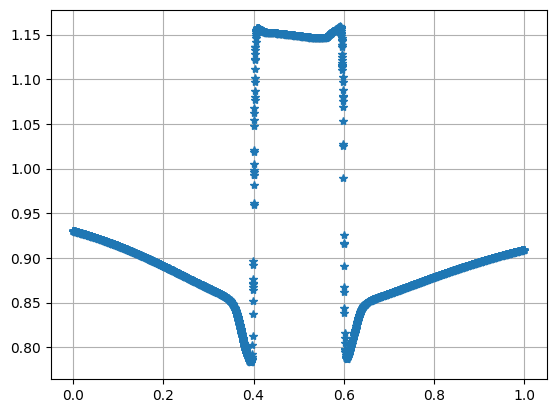

tensor(0.1720, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1703, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1690, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1676, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1663, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1650, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1637, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1624, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1612, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1600, device='cuda:0', grad_fn=<MulBackward0>)


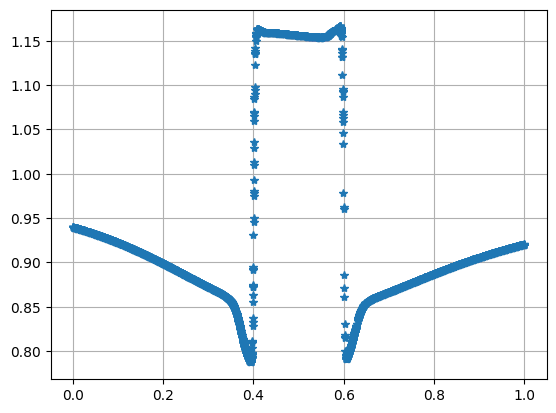

tensor(0.1588, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1576, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1553, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1554, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1537, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1529, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1505, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1490, device='cuda:0', grad_fn=<MulBackward0>)


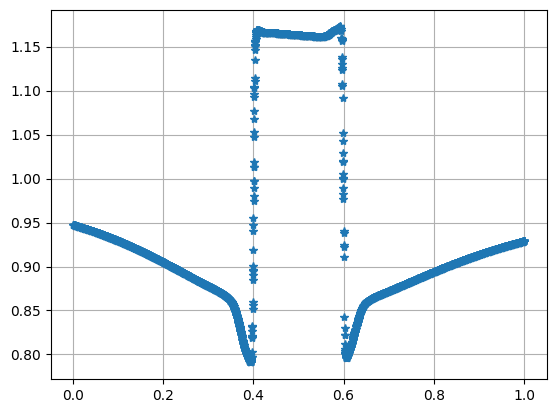

tensor(0.1478, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1467, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1457, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1447, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1437, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1427, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1408, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1406, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1388, device='cuda:0', grad_fn=<MulBackward0>)


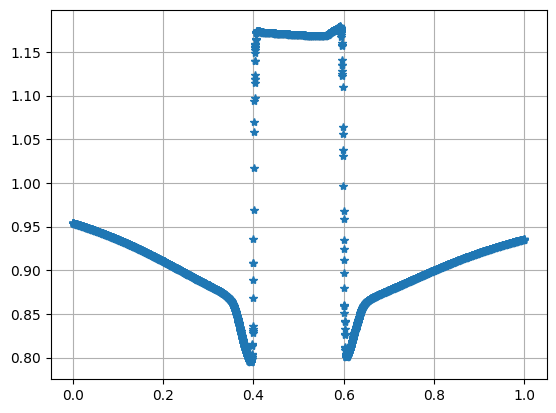

tensor(0.1380, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1369, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1350, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1341, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1332, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1323, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1313, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1305, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1308, device='cuda:0', grad_fn=<MulBackward0>)


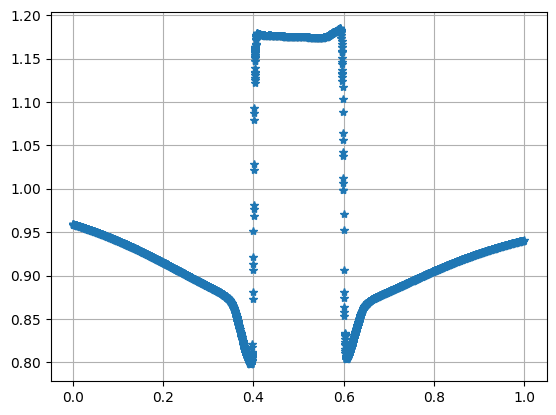

tensor(0.1295, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1279, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1269, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1260, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1251, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1247, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1239, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1226, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1216, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1207, device='cuda:0', grad_fn=<MulBackward0>)


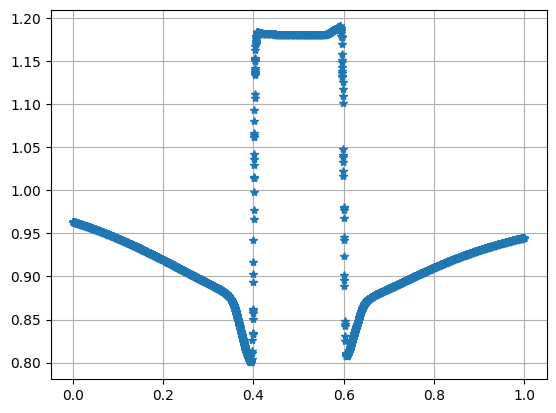

tensor(0.1198, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1189, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1180, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1172, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1163, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1149, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1145, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1132, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1121, device='cuda:0', grad_fn=<MulBackward0>)


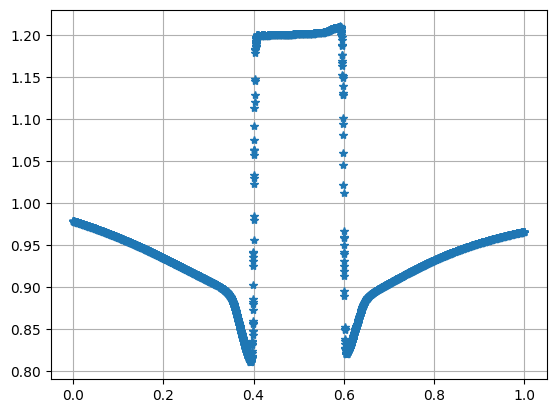

tensor(0.1111, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1059, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0962, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0841, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0724, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0615, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0551, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0378, device='cuda:0', grad_fn=<MulBackward0>)


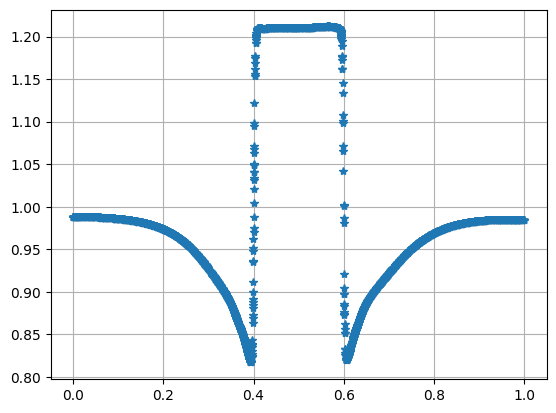

tensor(0.0331, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0237, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0188, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0171, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<MulBackward0>)


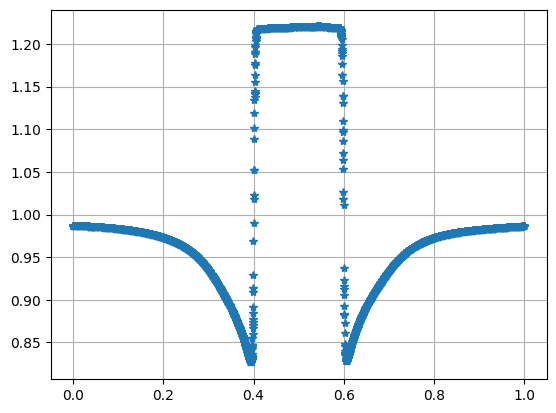

tensor(0.0120, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0102, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MulBackward0>)


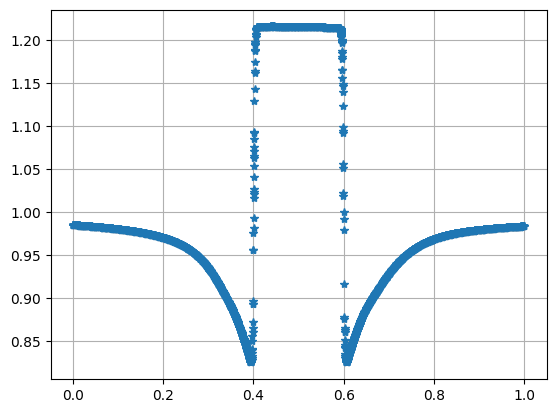

tensor(0.0063, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>)


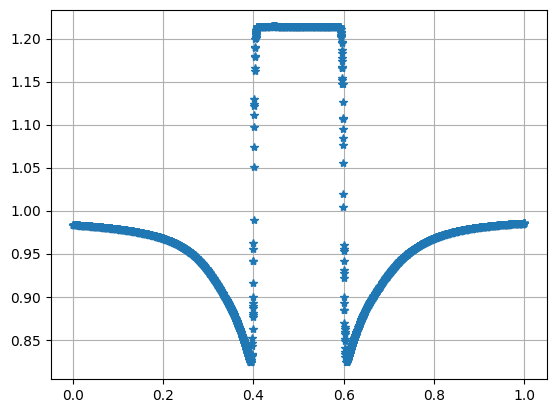

tensor(0.0038, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)


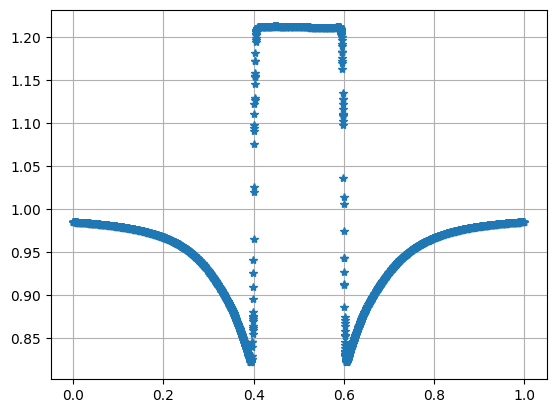

tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


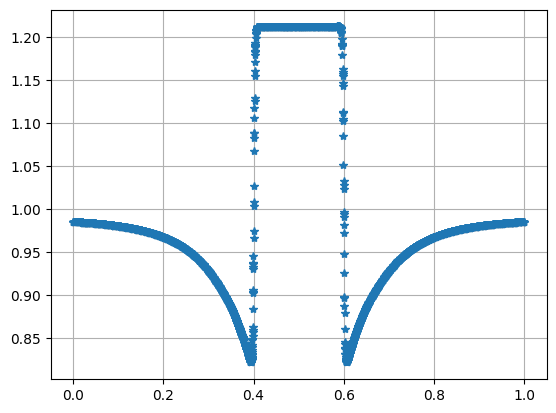

tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MulBackward0>)


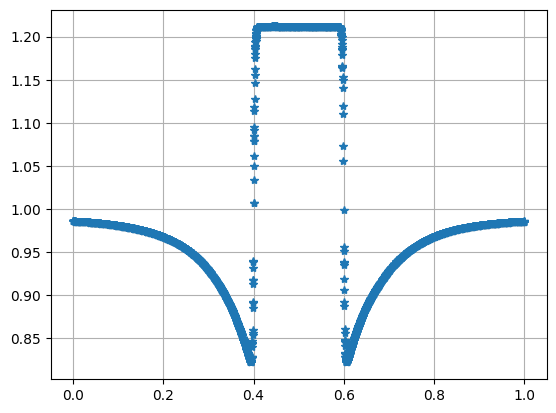

tensor(0.0014, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MulBackward0>)


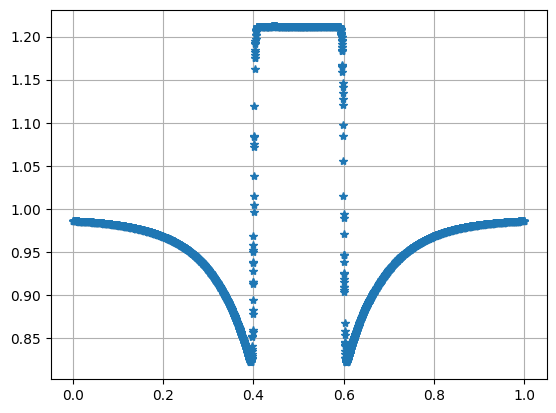

tensor(0.0011, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)


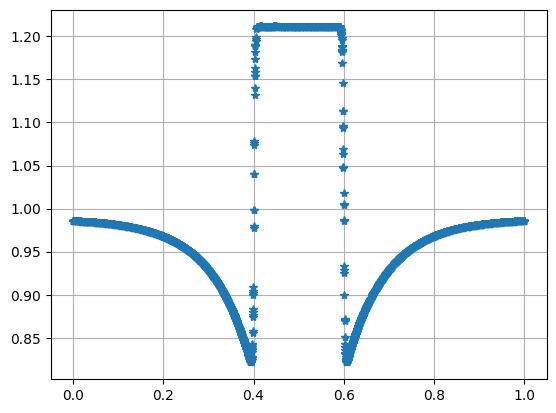

tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)


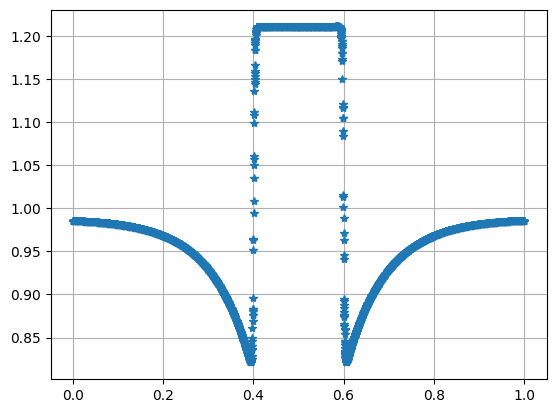

tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)


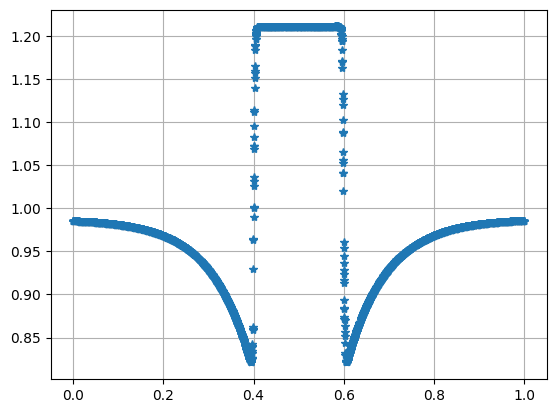

tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [30]:
learning_rate=5*10**-4
learning_rate2=1
criterion = nn.MSELoss()
optimizer = optim.Adam(netF.parameters(), lr=learning_rate)
optimizer2 = optim.LBFGS(netF.parameters(), lr=learning_rate2)

T=1
#training with 2000 adams iterations and 4000 L-BFGS iterations
for i in range(2000):
  loss=optimizer.step(closure)
  if (i%100 ==0):
    plot_results()
  if (i%10==0):
      print(loss*1)

for i in range(400):
  loss=optimizer2.step(closure)

  if (i%10 ==0):
    plot_results()
  if (i%1==0):
      print(loss*1)



Visualization of the produced solutions. The trained network gives a family of solutions for $0.2<a<0.6$.

In [34]:
ylist = np.linspace(0, 1, 400)
zlist = np.linspace(0, 1, 400)
ym, zm = np.meshgrid(ylist, zlist)

xp=0.5
a=0.3
ten=np.column_stack((ym.reshape(-1,1)*0 + xp  ,  ym.reshape(-1,1)  ,  zm.reshape(-1,1) , ym.reshape(-1,1)*0 + a))
ten=torch.tensor(ten).float().to(device)
ten.requires_grad=True


In [35]:
Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(ten)


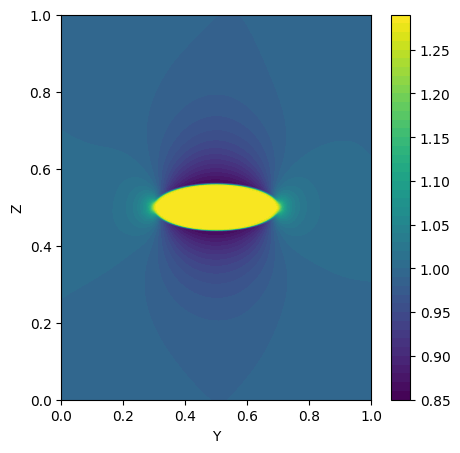

In [43]:
vnp=Hz.reshape(400,400).detach().cpu().numpy()

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = plt.colorbar(ax.contourf(ym, zm,vnp,50))
plt.xlabel('Y')
plt.ylabel('Z')
plt.show()

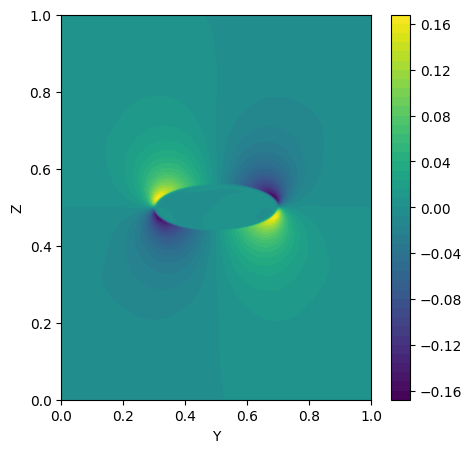

In [50]:
vnp=Hy.reshape(400,400).detach().cpu().numpy()

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = plt.colorbar(ax.contourf(ym, zm,vnp,50))
plt.xlabel('Y')
plt.ylabel('Z')

plt.show()